In [62]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [63]:
# vehicles = pd.read_csv('Data/NHTS_2022/vehpub.csv')
vehicles = pd.read_csv('../EV_TCO/Data/NHTS_2017/vehpub.csv')
vehicles.shape

(256115, 60)

In [64]:
vehicles['id'] = vehicles.apply(
    lambda row: f"{row['HOUSEID']:.0f}_{row['VEHID']:.0f}", axis = 1
)

In [65]:
# trips = pd.read_csv('Data/NHTS_2022/trippub.csv')
trips = pd.read_csv('../EV_TCO/Data/NHTS_2017/trippub.csv')
trips.shape

(923572, 115)

In [66]:
trips['id'] = trips.apply(
    lambda row: f"{row['HOUSEID']:.0f}_{row['VEHID']:.0f}", axis = 1
)

In [67]:
vehicle_ids = vehicles['id'].to_numpy()
vehicle_fuel_types = vehicles['HFUEL'].to_numpy()

ids_to_fuel_types = (
    {vehicle_id: vehicle_fuel_types[idx] for idx, vehicle_id in enumerate(vehicle_ids)}
)

trip_vehicle_ids = trips['id'].to_numpy()
trip_vehicle_fuel_types = np.zeros(trip_vehicle_ids.shape[0])

for idx, tvid in enumerate(trip_vehicle_ids):

    trip_vehicle_fuel_types[idx] = ids_to_fuel_types.get(tvid, -9)

trips['VEHFUEL'] = trip_vehicle_fuel_types

In [68]:
trips = trips[trips['PERSONID'] == trips['WHODROVE']]
trips = trips[trips['TRPHHVEH'] == 1]
trips.shape

(599226, 117)

In [69]:
trips_sel = [trips[trips['VEHFUEL'] == n] for n in [-1, 2, 3, 4]]

# trips_sel = [trips[trips['VEHFUEL'] == n] for n in [1, 6, 4, 5]]

In [70]:
def utility_factor(x, y):

    return np.array([np.clip(y, 0, x).sum() / y.sum() for x in x])

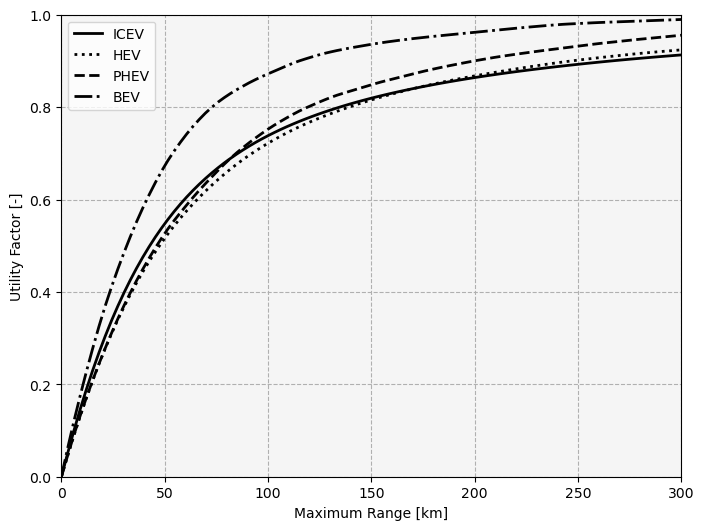

In [71]:
from scipy.stats import rv_histogram

bins = np.linspace(0, 500, 500)
x = np.linspace(0, 300, 100)

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

ax.plot(
    x, utility_factor(x, trips_sel[0].groupby(['id']).sum()['TRPMILES'] * 1.609),
    color = 'k', ls = '-', lw = 2, label = 'ICEV',
)

ax.plot(
    x, utility_factor(x, trips_sel[3].groupby(['id']).sum()['TRPMILES'] * 1.609),
    color = 'k', ls = ':', lw = 2, label = 'HEV',
)

ax.plot(
    x, utility_factor(x, trips_sel[1].groupby(['id']).sum()['TRPMILES'] * 1.609),
    color = 'k', ls = '--', lw = 2, label = 'PHEV',
)

ax.plot(
    x, utility_factor(x, trips_sel[2].groupby(['id']).sum()['TRPMILES'] * 1.609),
    color = 'k', ls = '-.', lw = 2, label = 'BEV',
)

kw = {
    'facecolor': 'whitesmoke',
    'xlabel': 'Maximum Range [km]',
    'ylabel': 'Utility Factor [-]',
    'xlim': (0, 300),
    'ylim': (0, 1),
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

ax.legend()

# fig.savefig('Paper/figs/uf_2017.png', bbox_inches = 'tight', dpi = 300)

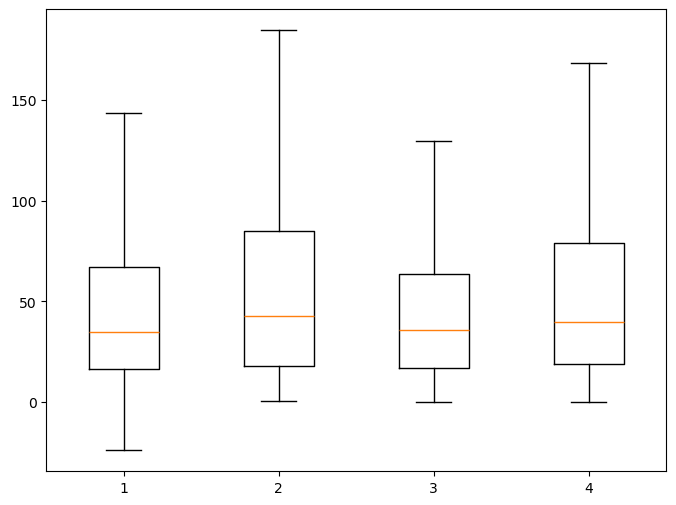

In [80]:
from scipy.stats import rv_histogram

bins = np.linspace(0, 500, 500)
x = np.linspace(0, 300, 100)

x = [df.groupby(['id']).sum()['TRPMILES'] * 1.609 for df in trips_sel]

fig, ax = plt.subplots(1, 1, figsize = (8, 6))

_ = ax.boxplot(
    x, showfliers = False,
    # color = 'k', ls = '-', lw = 2, label = 'ICEV',
)
# ax.plot(
#     x, utility_factor(x, trips_sel[1].groupby(['id']).sum()['TRPMILES'] * 1.609),
#     color = 'k', ls = '--', lw = 2, label = 'PHEV',
# )

# ax.plot(
#     x, utility_factor(x, trips_sel[2].groupby(['id']).sum()['TRPMILES'] * 1.609),
#     color = 'k', ls = '-.', lw = 2, label = 'BEV',
# )

# kw = {
#     'facecolor': 'whitesmoke',
#     'xlabel': 'Maximum Range [km]',
#     'ylabel': 'Utility Factor [-]',
#     'xlim': (0, 300),
#     'ylim': (0, 1),
# }

# ax.set(**kw)

# kw = {
#     'ls': '--',
# }

# ax.grid(**kw)

# ax.legend()

# fig.savefig('Paper/figs/uf_2017.png', bbox_inches = 'tight', dpi = 300)